# 6.6 Sourcing & Analyzing Time-Series Data

🔎 **Introduction:**  
While the primary analysis in the broader project focuses on data at the **county level**, the selected dataset represents **national-level** trends in real median household income. Despite the difference in geographic scale, the dataset offers essential historical and contextual grounding.  
By examining long-term income patterns across the United States, the analysis aims to uncover macroeconomic dynamics that may influence disparities in healthcare access, affordability, and general quality of life at the local level. This **national time series** thus serves as a valuable reference point, supporting and complementing the county-level findings of the "Best Counties to Live in the U.S." project.


### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data
#### 6. Arima

#### 1. Importing your libraries and data

In [5]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

### Quandl / Nasdaq Data Link Access Attempt

I attempted to access the U.S. Real Median Household Income dataset from FRED via the `nasdaq-data-link` (formerly Quandl) API using the following code:

```python
# Install the library (if not done yet)
!pip install nasdaq-data-link

# Import the library
import nasdaqdatalink as nq

# Set your API key
nq.ApiConfig.api_key = "-_Lugk_aEWogDisHesEMupdate"

# Get the dataset
income_df = nq.get("FRED/MEHOINUSA672N")

# Preview the data
income_df.head()


DataLinkError: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@data.nasdaq.com.


### 📌 Data Source Documentation

The dataset used in this analysis is **Real Median Household Income in the United States**, accessed via the `pandas_datareader` library using the FRED (Federal Reserve Economic Data) API.

- **Dataset Code:** `MEHOINUSA672N`
- **Original Source:** U.S. Census Bureau  
- **Collected through:** Current Population Survey (CPS)
- **Published by:** Federal Reserve Bank of St. Louis on the FRED platform  
- **Data Type:** Real median household income (adjusted to 2012 dollars)  
- **Frequency:** Annual  
- **Time Range:** Approximately 1984 to the most recent year (2023 or 2024)

**Official FRED Dataset Link:**  
[https://fred.stlouisfed.org/series/MEHOINUSA672N](https://fred.stlouisfed.org/series/MEHOINUSA672N)

This dataset was selected because it aligns with the broader "Best Counties to Live in the U.S." project by providing insight into national income trends over time. It serves as a useful benchmark to compare local-level income trends and assess economic well-being.


In [8]:
!pip install pandas_datareader

import pandas_datareader.data as web
from datetime import datetime

start = datetime(1984, 1, 1)
end = datetime(2024, 12, 31)

mi_df = web.DataReader("MEHOINUSA672N", "fred", start, end)
mi_df.head()


,MEHOINUSA672N
DATE,
1984-01-01,58930
1985-01-01,60050
1986-01-01,62280
1987-01-01,63060
1988-01-01,63530


### General check

In [10]:
mi_df.shape

(40, 1)

In [11]:
mi_df.columns

Index(['MEHOINUSA672N'], dtype='object')

In [12]:
type(mi_df)

pandas.core.frame.DataFrame

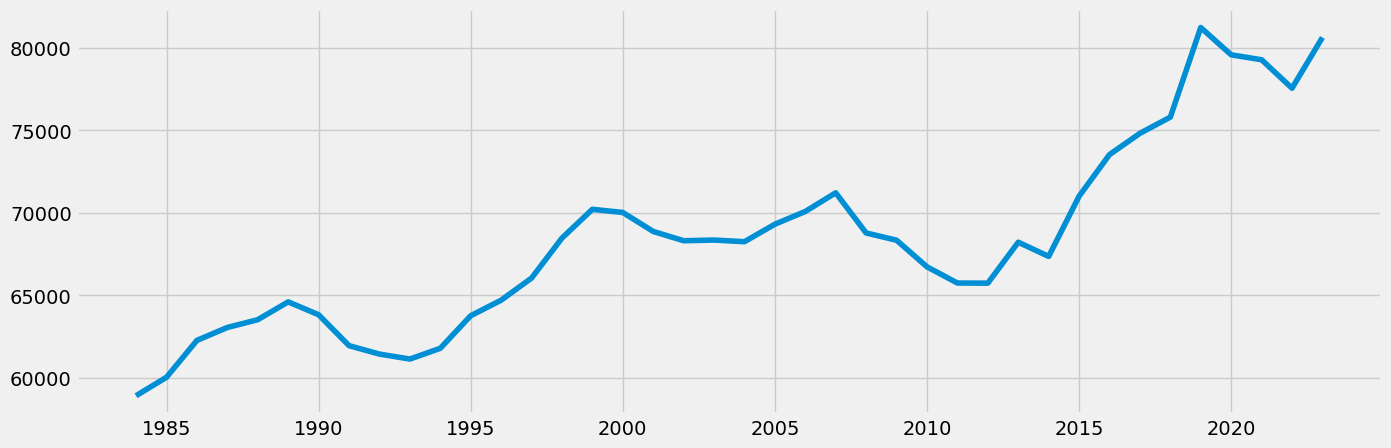

In [13]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(mi_df)

In [14]:
# Since the data has only 40 point we will not make any subset of it

In [15]:
# Renaming column

mi_df.rename(columns = {'MEHOINUSA672N' : "Median Income"}, inplace = True)

In [16]:
mi_df.isnull().sum() #cheking nulla

Median Income    0
dtype: int64

### 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(mi_df, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

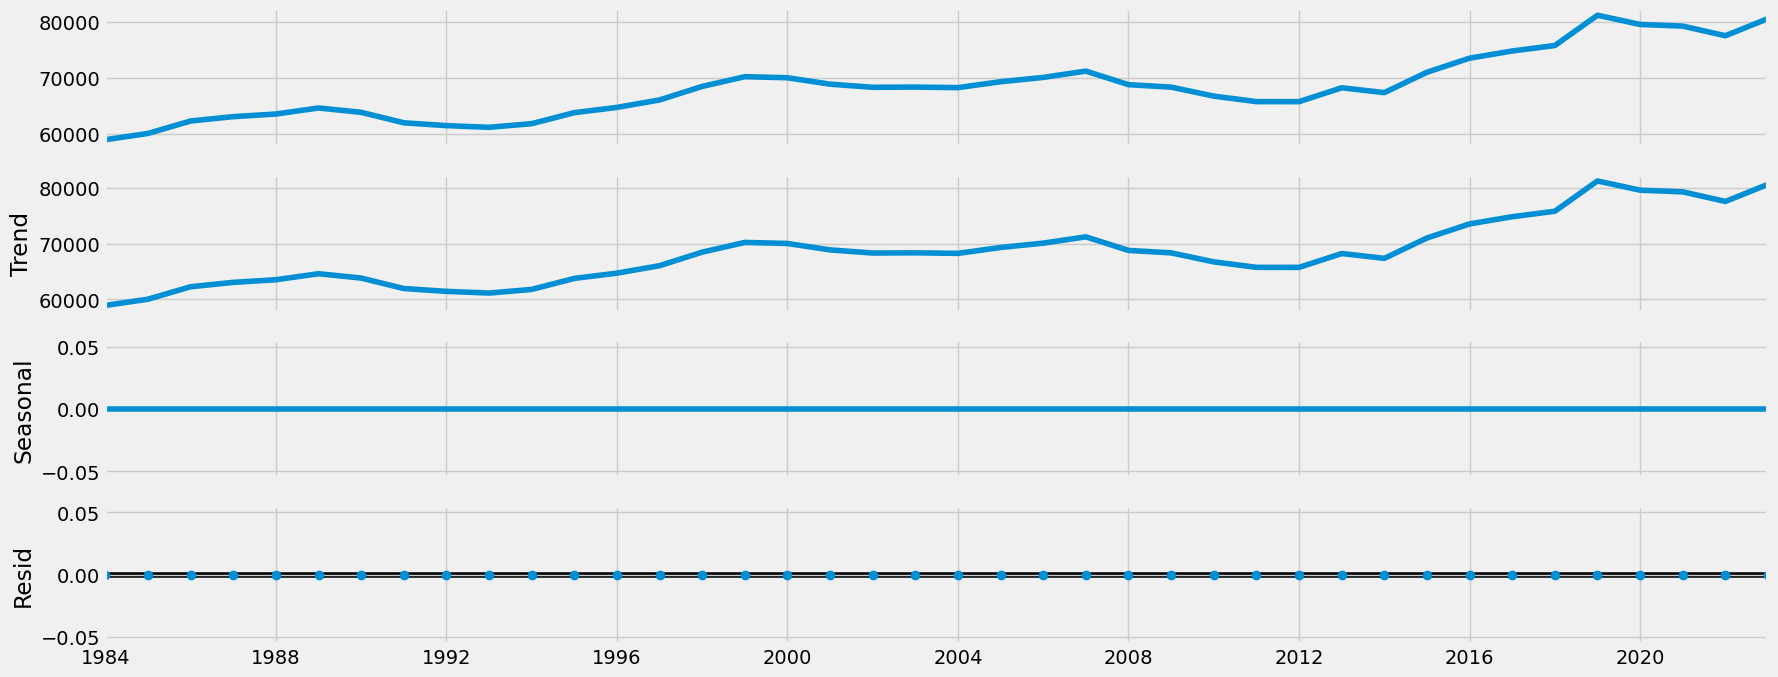

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

### Note on Time Series Decomposition

This dataset consists of **annual observations** of U.S. real median household income from 1984 to 2023. As a result:

- The **trend component** is meaningful and clearly visible, reflecting long-term income changes.
- The **seasonal component is not present**, as the data is reported yearly and does not contain intra-year repeating patterns.
- The **residual component is minimal**, since most of the variation is captured by the trend and there is no seasonality to account for.

This behavior is expected for macroeconomic time series with low frequency (annual data).


### 4. Testing for stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(mi_df['Median Income'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.084709
p-value                         0.950940
Number of Lags Used             6.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [24]:
# This is definitely non-stationary 

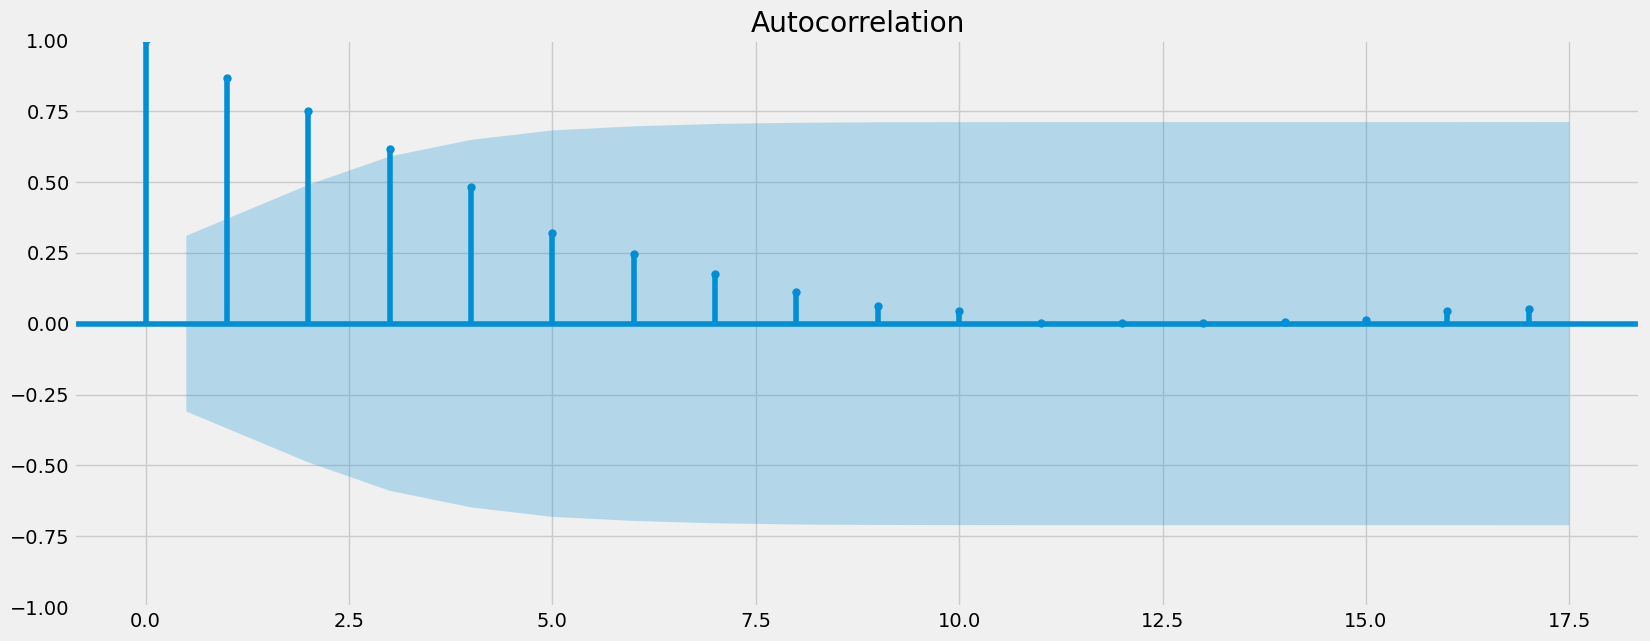

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(mi_df)
plt.show()

### 5. Stationarizing the data

In [27]:
data_diff = mi_df - mi_df.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [28]:
data_diff.dropna(inplace = True) # dropping NA

In [29]:
data_diff.head()

,Median Income
DATE,
1985-01-01,1120.0
1986-01-01,2230.0
1987-01-01,780.0
1988-01-01,470.0
1989-01-01,1080.0


In [30]:
data_diff.columns

Index(['Median Income'], dtype='object')

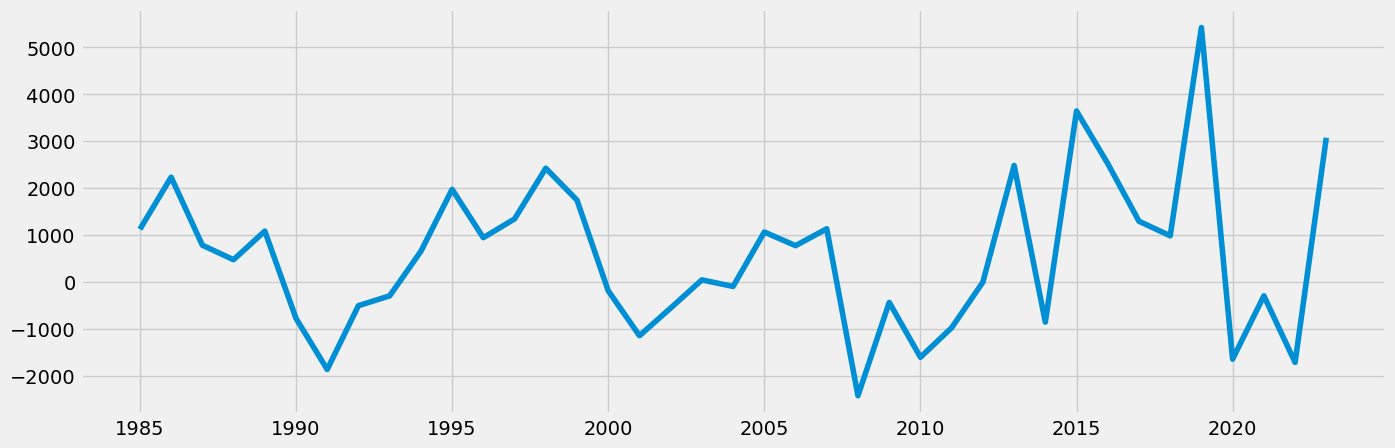

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [73]:
# Ensure proper column names
data_diff_df = pd.DataFrame(data_diff).reset_index()
data_diff_df.columns = ['Index', 'Diff_Value']


In [77]:
# Define folder and filename
folder = "/Users/emilsafarov/Library/CloudStorage/OneDrive-Personal/CF/A6/7_Tableau_Dashboard"
filename = "time_series.csv"

# Join path
file_path = os.path.join(folder, filename)

# Export CSV
data_diff_df.to_csv(file_path, index=False)
print(f"Saved to: {file_path}")


Saved to: /Users/emilsafarov/Library/CloudStorage/OneDrive-Personal/CF/A6/7_Tableau_Dashboard/time_series.csv


In [32]:
dickey_fuller(data_diff) #retesting

Dickey-Fuller Stationarity test:
Test Statistic                 -4.662005
p-value                         0.000099
Number of Lags Used             4.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


After first differencing, the Dickey-Fuller test shows a **significant p-value (0.0001)** and a **test statistic lower than all critical values**, indicating the series is now **stationary**.


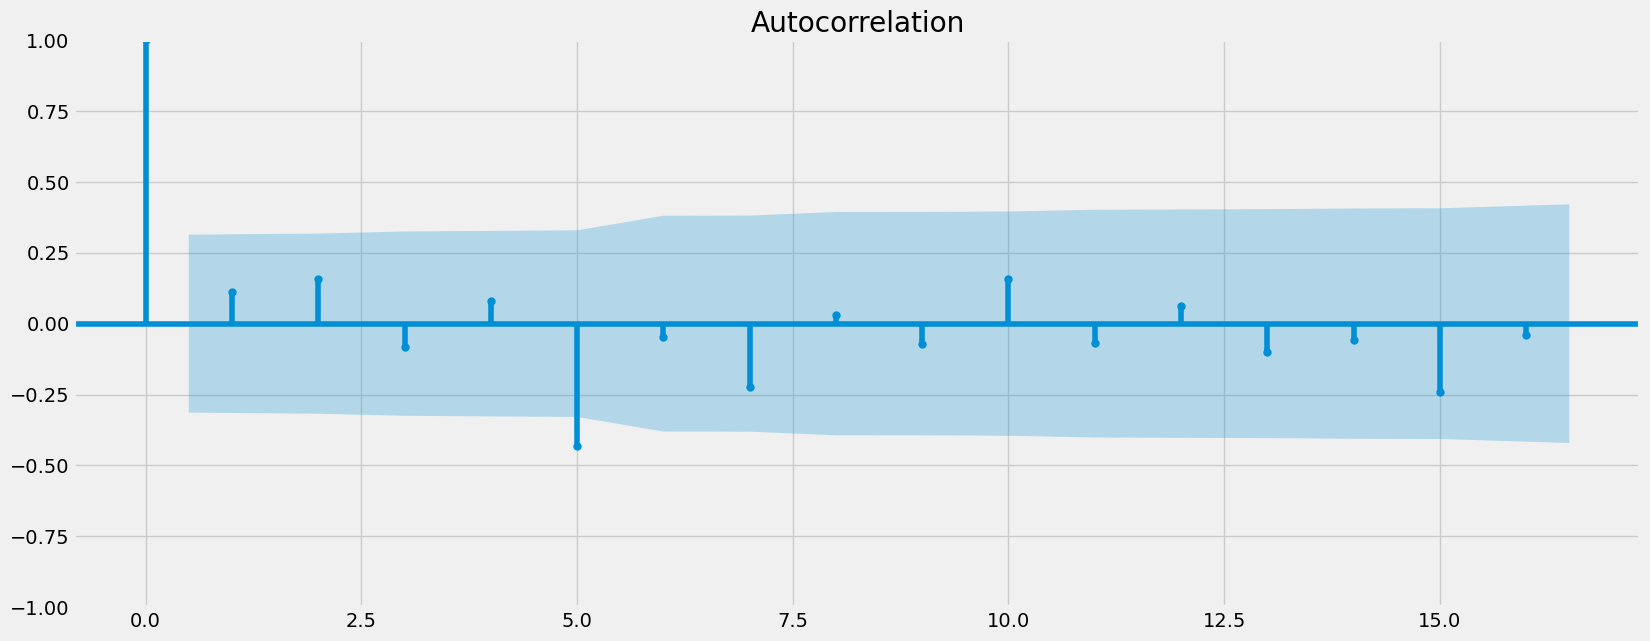

In [34]:
plot_acf(data_diff)
plt.show()

The differencing successfully removed autocorrelation

 ### 6. ARIMA Modeling

In [37]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [38]:
model = ARIMA(data_diff['Median Income'], order=(1, 1, 1))
model_fit = model.fit()

In [39]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          Median Income   No. Observations:                   39
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -336.820
Date:                Tue, 13 May 2025   AIC                            679.640
Time:                        04:06:43   BIC                            684.552
Sample:                    01-01-1985   HQIC                           681.388
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1358      0.152      0.896      0.370      -0.161       0.433
ma.L1         -0.9996      0.209     -4.791      0.000      -1.409      -0.591
sigma2      2.715e+06   7.77e-08   3.49e+13      0.0

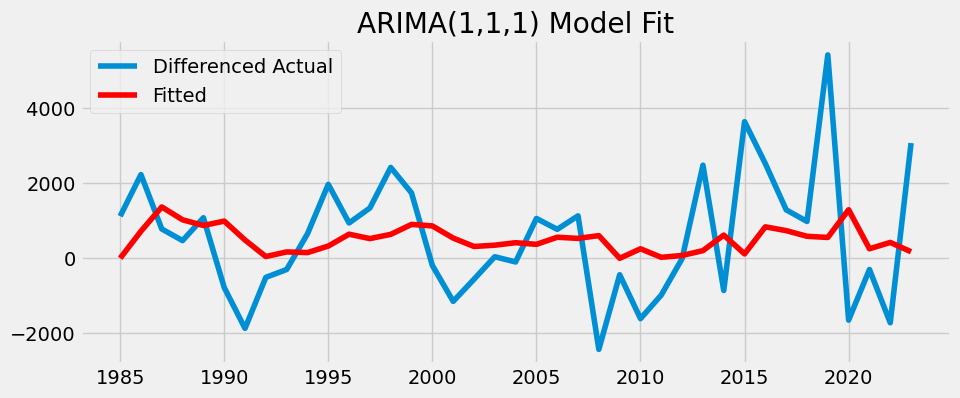

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(data_diff['Median Income'], label='Differenced Actual')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.title('ARIMA(1,1,1) Model Fit')
plt.legend()
plt.show()


In [41]:
forecast_diff = model_fit.forecast(steps=5)
print(forecast_diff)


2024-01-01    896.334429
2025-01-01    601.050315
2026-01-01    560.937103
2027-01-01    555.487877
2028-01-01    554.747621
Freq: YS-JAN, Name: predicted_mean, dtype: float64


In [42]:
last_value = data_diff['Median Income'].iloc[-1]
forecast_absolute = forecast_diff.cumsum() + last_value
print(forecast_absolute)


2024-01-01    3966.334429
2025-01-01    4567.384744
2026-01-01    5128.321847
2027-01-01    5683.809724
2028-01-01    6238.557345
Freq: YS-JAN, Name: predicted_mean, dtype: float64
